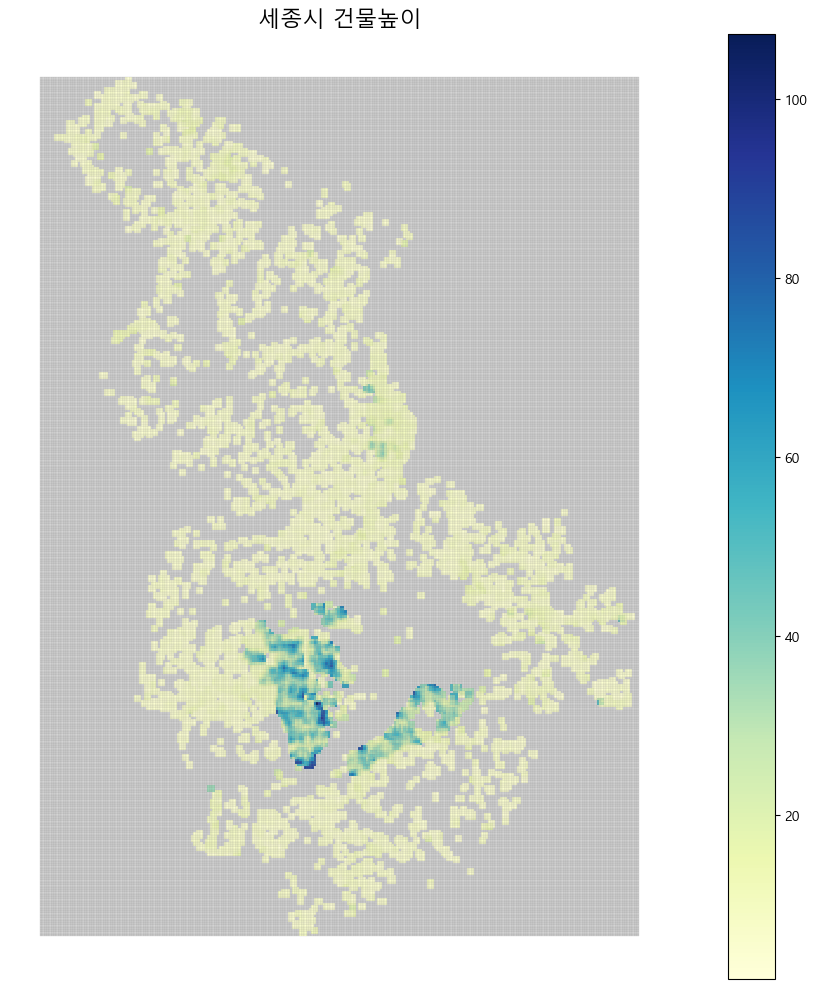

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib as mlp
from tqdm import tqdm

# 1 Shapefile 불러오기
gdf = gpd.read_file("data/건물높이_원천데이터/세종시/nlsp_021002013.shp")
gdf = gdf.to_crs(epsg=5179)  # EPSG:5179 (Korea 2000 / Central Belt)로 투영

# 2 격자 생성 파라미터 설정
cell_size = 100  # 100m 격자
minx, miny, maxx, maxy = gdf.total_bounds

# 3 격자 생성
cols = list(np.arange(minx, maxx, cell_size))
rows = list(np.arange(miny, maxy, cell_size))
grid_cells = []
for x in cols:
    for y in rows:
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

# 4 공간 조인 및 평균 건물 높이 계산
gdf["height"] = gdf["val"]  # 건물 높이 필드를 val로 설정
joined = gpd.sjoin(grid, gdf[["geometry", "height"]], how="left", predicate="intersects")
result = joined.groupby(joined.index).agg({"height": "mean"}).rename(columns={"height": "avg_height"})
grid["avg_height"] = result["avg_height"]

# 5 격자 중심 좌표 추출
grid["x"] = grid.centroid.x
grid["y"] = grid.centroid.y

# 6 CSV로 저장
grid[["x", "y", "avg_height"]].to_csv("data/건물높이/세종시_건물높이.csv", index=False, encoding="utf-8-sig")

# 7 시각화: 건물 높이 격자 Choropleth
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(
    column="avg_height",
    ax=ax,
    cmap="YlGnBu",        # 또는 'plasma', 'OrRd', 'YlGnBu' 등
    legend=True,
    edgecolor="gray",
    linewidth=0.1,
    missing_kwds={"color": "lightgray", "label": "No data"}
)
ax.set_title("세종시 건물높이", fontsize=16) 
ax.set_axis_off()
plt.tight_layout()
plt.show()